In [122]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle
from statistics import mode
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
from scipy import interp

from sklearn.metrics import confusion_matrix, auc, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score

from PreprocessFcns import *

%matplotlib inline

sns.set_context('poster',font_scale=1)

In [123]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)

#             f, t, th = roc_curve(yte,yscore)
#             print(auroc,auc(f,t))

            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

def LOSOCV_Multi(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)

            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                        
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    
#                     fpr=np.linspace(0,1,101); tpr=[]
# 
#                     if len(np.unique(yte))>1:                
#                         nscores = np.sort(np.column_stack((ys[yt==0],yt[yt==0])),axis=0)
#                         neg_counts = sum(yt==0)
#                         for f in fpr:
#                             ind = neg_counts-int(neg_counts*f)-1
#                             t = (nscores[ind])[0]
#                             print(t)
#                             if f==1:
#                                 t = 0
#                             tpr_t = sum(ys[yt==1]>t) / sum(yt==1)
#                             tpr.append(tpr_t) 

#                     print(auc(fpr,tpr),roc_auc_score(yt,ys))
#                     print(fpr, tpr)
                            
#                     fpr = np.asarray(fpr); tpr = np.asarray(tpr)*np.mean(yt)
#                     fpr_all.append(fpr); tpr_all.append(tpr)
                    
                    
                    
                    fpr, tpr, thresh = roc_curve(yte_bin[:,i],yscore[:,i],pos_label=1)
#                     print(min(yscore[yte_bin[:,i]==1,i]),max(yscore[yte_bin[:,i]==0,i]))
#                     print(fpr,tpr,thresh)
#                     print(auc(fpr,tpr),roc_auc_score(yte_bin[:,i],yscore[:,i]))
                    tprs.append(interp(fpr_mean,fpr,tpr)*np.mean(yte_bin[:,i]))
                tpr = sum(tprs)
#                 print(tpr)
                fpr = fpr_mean
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])
            
            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,auroc=%.3f'%(s,auroc))
            s+=1

        print('auroc=%.3f+/-%.3f'%(np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'tpr':tpr_all, 'fpr':fpr_all, 'auroc': auroc_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
        
    return results,groupres

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [124]:
# gr = LOSOCV_Multi(Data,X,y,groups,models)

# Accelerometer and Gyroscope Comparisons

## Tremor

In [125]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

In [126]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.226,rec=0.380,Spec=0.893,auroc_train=1.000,auroc=0.747

Subj/Visit 1,prec=0.673,rec=0.155,Spec=0.953,auroc_train=1.000,auroc=0.762

Subj/Visit 2,prec=0.613,rec=0.376,Spec=0.951,auroc_train=1.000,auroc=0.827

Subj/Visit 3,prec=0.209,rec=0.541,Spec=0.868,auroc_train=1.000,auroc=0.788

Subj/Visit 4,prec=0.473,rec=0.244,Spec=0.876,auroc_train=1.000,auroc=0.716

Subj/Visit 5,prec=0.629,rec=0.276,Spec=0.866,auroc_train=1.000,auroc=0.717

Subj/Visit 6,prec=0.582,rec=0.577,Spec=0.957,auroc_train=1.000,auroc=0.910

Subj/Visit 7,prec=0.415,rec=0.436,Spec=0.968,auroc_train=1.000,auroc=0.904

Subj/Visit 8,prec=0.940,rec=0.454,Spec=0.969,auroc_train=1.000,auroc=0.874


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.840,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.222,rec=0.028,Spec=0.921,auroc_train=1.000,auroc=0.268

Subj/Visit 11,prec=0.953,rec=0.532,Spec=0.904,auroc_train=1.000,auroc=0.856

Subj/Visit 12,prec=0.020,rec=0.429,Spec=0.865,auroc_train=1.000,auroc=0.816
f1_test=0.338+/-0.211, prec=0.458+/-0.300, rec=0.340+/-0.181, auprc=0.480+/-0.264, auroc=0.765+/-0.163
Elapsed time = 1.104 min


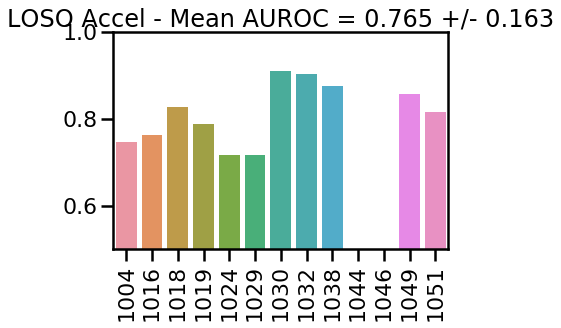

In [127]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [128]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.260,rec=0.435,Spec=0.898,auroc_train=1.000,auroc=0.795

Subj/Visit 1,prec=0.776,rec=0.169,Spec=0.970,auroc_train=1.000,auroc=0.784

Subj/Visit 2,prec=0.669,rec=0.441,Spec=0.956,auroc_train=1.000,auroc=0.801

Subj/Visit 3,prec=0.258,rec=0.554,Spec=0.897,auroc_train=1.000,auroc=0.766

Subj/Visit 4,prec=0.577,rec=0.208,Spec=0.930,auroc_train=1.000,auroc=0.722

Subj/Visit 5,prec=0.697,rec=0.366,Spec=0.869,auroc_train=1.000,auroc=0.759

Subj/Visit 6,prec=0.736,rec=0.802,Spec=0.970,auroc_train=1.000,auroc=0.935

Subj/Visit 7,prec=0.514,rec=0.731,Spec=0.964,auroc_train=1.000,auroc=0.936

Subj/Visit 8,prec=0.939,rec=0.492,Spec=0.966,auroc_train=1.000,auroc=0.871


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.824,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.698,rec=0.181,Spec=0.937,auroc_train=1.000,auroc=0.561

Subj/Visit 11,prec=0.951,rec=0.555,Spec=0.897,auroc_train=1.000,auroc=0.868

Subj/Visit 12,prec=0.021,rec=0.571,Spec=0.830,auroc_train=1.000,auroc=0.839
f1_test=0.409+/-0.229, prec=0.546+/-0.305, rec=0.423+/-0.224, auprc=0.576+/-0.252, auroc=0.803+/-0.097
Elapsed time = 1.277 min


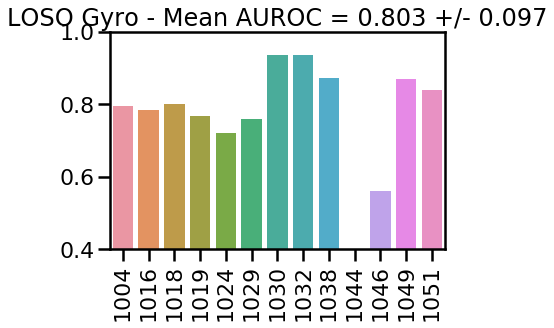

In [129]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [130]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.280,rec=0.380,Spec=0.920,auroc_train=1.000,auroc=0.792

Subj/Visit 1,prec=0.731,rec=0.177,Spec=0.960,auroc_train=1.000,auroc=0.776

Subj/Visit 2,prec=0.598,rec=0.361,Spec=0.950,auroc_train=1.000,auroc=0.825

Subj/Visit 3,prec=0.273,rec=0.608,Spec=0.895,auroc_train=1.000,auroc=0.801

Subj/Visit 4,prec=0.509,rec=0.218,Spec=0.904,auroc_train=1.000,auroc=0.707

Subj/Visit 5,prec=0.657,rec=0.361,Spec=0.845,auroc_train=1.000,auroc=0.731

Subj/Visit 6,prec=0.706,rec=0.757,Spec=0.968,auroc_train=1.000,auroc=0.929


KeyboardInterrupt: 

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

In [ ]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [ ]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

In [ ]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

In [ ]:
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsBradykinesiaLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [ ]:
#Hand Sensors

# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [ ]:
# Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

In [ ]:
resultsSensor = np.load('Results/resultsTremorHand.npy')
resultsWatch = np.load('Results/resultsTremorWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Bradykinesia

In [ ]:
#Hand Sensors

# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [ ]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

In [ ]:
resultsSensor = np.load('Results/resultsBradykinesiaHand.npy')
resultsWatch = np.load('Results/resultsBradykinesiaWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

# Data Loss Comparisons

In [ ]:
sensor_sample_lens = pd.read_csv('Z:CIS-PD Study\\Sensor Sample Lengths.csv',index_col=0)
watch_sample_lens = pd.read_csv('Z:CIS-PD Study\\Watch Sample Lengths.csv',index_col=0)

In [ ]:
sample_lens = pd.DataFrame()
sample_lens['mean'] = pd.Series([np.mean(sensor_sample_lens['Samples']),np.mean(watch_sample_lens['Samples'])])
sample_lens['mode'] = pd.Series([mode(sensor_sample_lens['Samples']),mode(watch_sample_lens['Samples'])])
sample_lens['std'] = pd.Series([np.std(sensor_sample_lens['Samples']),np.std(watch_sample_lens['Samples'])])
sample_lens.index = ['Sensor','Watch']

sample_lens

# Multiclass Comparisons

# Accelerometer and Gyroscope Comparisons

## Tremor

In [ ]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

In [ ]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

In [ ]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [ ]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

In [ ]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

In [ ]:
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsBradykinesiaLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [ ]:
#Hand Sensors

# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [ ]:
# Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

In [ ]:
resultsSensor = np.load('Results/resultsTremorHand.npy')
resultsWatch = np.load('Results/resultsTremorWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Bradykinesia

In [ ]:
#Hand Sensors

# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [ ]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

In [ ]:
resultsSensor = np.load('Results/resultsBradykinesiaHand.npy')
resultsWatch = np.load('Results/resultsBradykinesiaWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Make Figures w/ ROC Curves

### Tremor

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'True Positive Rate')

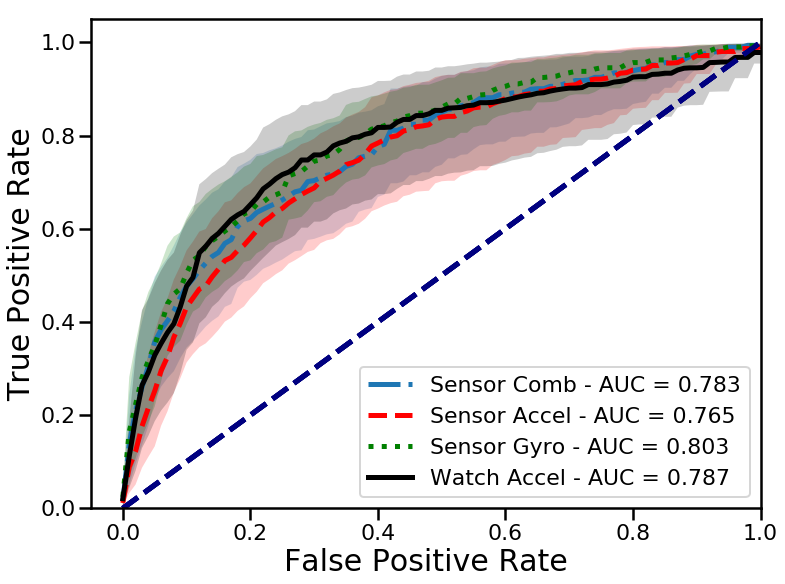

In [134]:
data = Trem_Comb
plt.figure(figsize=(12,9))
lw = 5
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname='Sensor Comb',ls='-.',lw=5)
for data, c, name, ls in zip([Trem_Accel,Trem_Gyro,Trem_Watch],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls = ls,lw=5)
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'True Positive Rate')

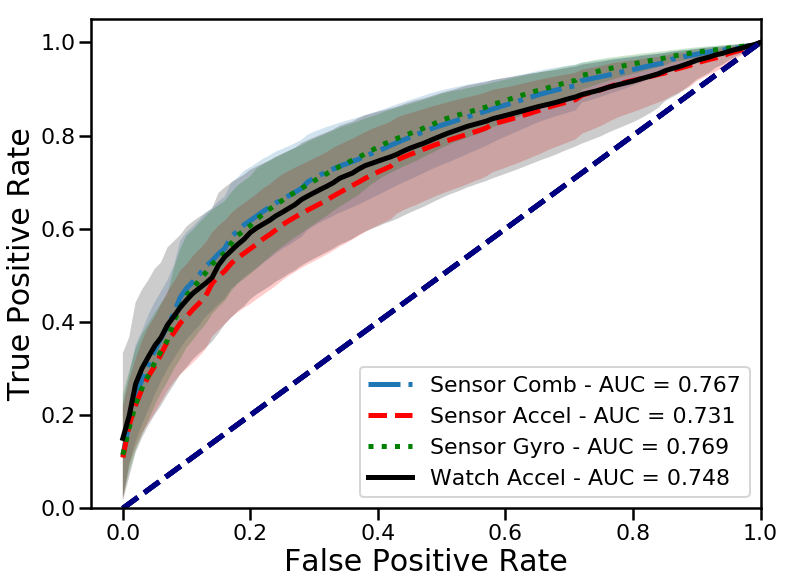

In [135]:
data = Trem_Comb_Multi
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([Trem_Accel_Multi,Trem_Gyro_Multi,Trem_Watch_Multi],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c,ls = ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)

### Bradykinesia

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'True Positive Rate')

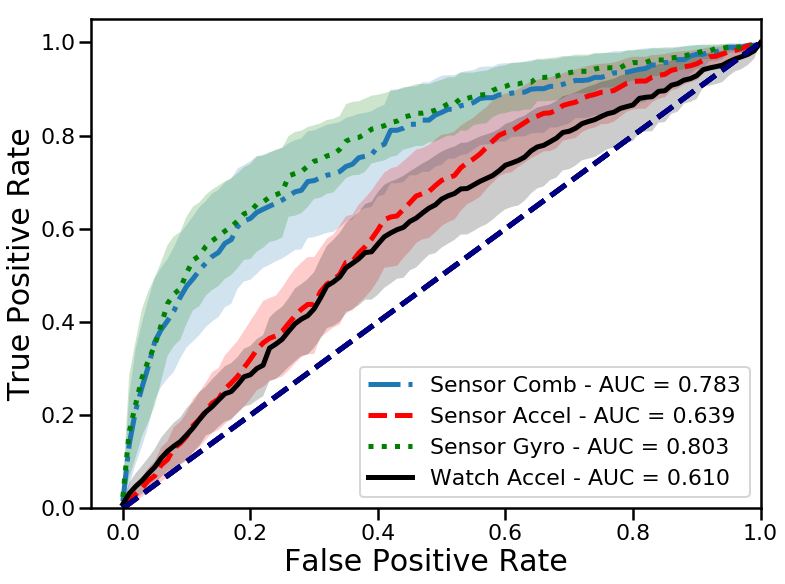

In [136]:
data = Brad_Comb
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([Brad_Accel,Brad_Gyro,Brad_Watch],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls=ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)

C:\Users\nshawen\AppData\Roaming\Python\Python36\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'True Positive Rate')

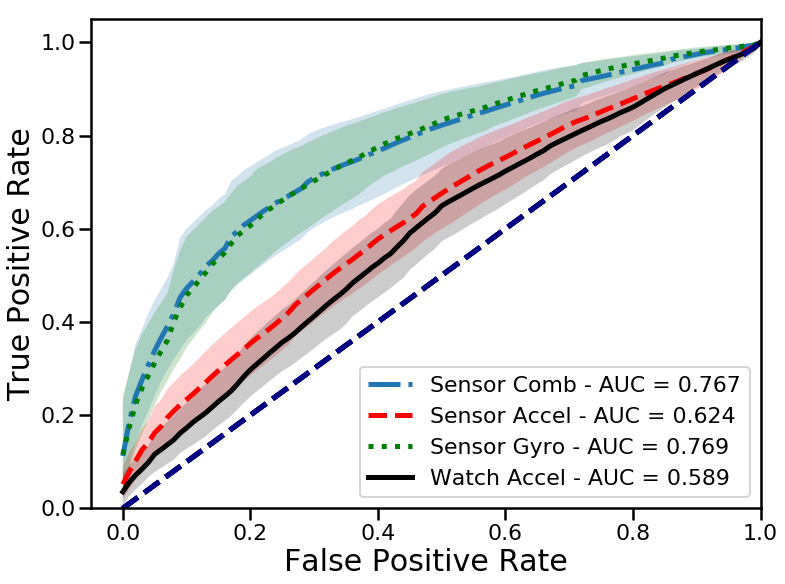

In [137]:
data = Brad_Comb_Multi
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([Brad_Accel_Multi,Brad_Gyro_Multi,Brad_Watch_Multi],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']), 
             plotname = name, ax = ax, col = c,ls = ls,lw=lw)

ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)

In [132]:
def pickleSave(filename,var):
    with open(filename,'wb') as handle:
        pickle.dump(var,handle)

In [133]:
varbs = [Trem_Accel,Trem_Accel_Multi,Trem_Comb,Trem_Comb_Multi,Trem_Gyro,Trem_Gyro_Multi,Trem_Watch,Trem_Watch_Multi,
         Brad_Accel,Brad_Accel_Multi,Brad_Comb,Brad_Comb_Multi,Brad_Gyro,Brad_Gyro_Multi,Brad_Watch,Brad_Watch_Multi]
files = ['Trem_Accel','Trem_Accel_Multi','Trem_Comb','Trem_Comb_Multi','Trem_Gyro','Trem_Gyro_Multi','Trem_Watch','Trem_Watch_Multi',
         'Brady_Accel','Brady_Accel_Multi','Brady_Comb','Brady_Comb_Multi','Brady_Gyro','Brady_Gyro_Multi','Brady_Watch','Brady_Watch_Multi']
for f,v in zip(files,varbs):
    pickleSave('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\'+f,v)

# Accelerometer and EMG comparisons

In [7]:
Data_accel = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data 62.5Hz.csv')
Data_EMG = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv',index_col=0).iloc[:,6:]

Datafull = pd.DataFrame
Data_accel = Data_accel.reset_index(drop=True)
Data_EMG = Data_EMG.reset_index(drop=True)
Datafull = pd.concat((Data_accel.iloc[:,:6],Data_EMG,Data_accel.iloc[:,13]),axis=1)

In [8]:
Datafull.head()

,Unnamed: 0,Subject,Visit,Task,Bradykinesia,Tremor,RMS0,mean0,var0,skew0,...,MAV9,RMS10,mean10,var10,skew10,kurt10,binen10,energy10,MAV10,meanY
0,0.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000593
1,1.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000049
2,2.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000050
3,3.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000058,0.000129,0.000009,0.399398,...,0.000002,1.818105e-08,4.014991e-09,9.088620e-07,-0.036244,1.759811,2.024107,2.064290e-09,6.495575e-07,0.000045
4,4.0,1004.0,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000201


In [9]:
s = 'flexor_digitorum__accel'
print('%s,discarded %d rows'%(s,sum(Datafull[s].apply(type) == float)))
Datafull = Datafull[Datafull[s].apply(type) != float]

s = 'Tremor'
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

s = Data_EMG.columns.values[6]
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

KeyError: 'flexor_digitorum__accel'

In [ ]:
def feature_unpack_forearm(Datafull):
    #unpack features
    colnames_accel =['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']
    colnames_accel =[i+' accel' for i in colnames_accel]

    sensor = 'flexor_digitorum__accel'
    
    Datafinal = pd.DataFrame()
    
    for i in range(len(Datafull)):
        F = Datafull[sensor].iloc[i]
        F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        Datafinal = pd.concat((Datafinal,F))
    Datafinal=Datafinal.reset_index(drop=True)
    Datafull=Datafull.reset_index(drop=True)
    Datafinal = pd.concat((Datafull.iloc[:,:94],Datafinal),axis=1)

    return Datafinal

In [ ]:
Datafull = feature_unpack_forearm(Datafull)

In [ ]:
Datafull.head()

## Leave One Subject Out

### Tremor

In [ ]:
#LOSO EMG Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOEMG.png',format='png',dpi=1000)

In [ ]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.55,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined EMG and Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsTremorLOSOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOSOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO.png',format='png',dpi=1000)

### Bradykinesia

In [ ]:
#LOSO EMG Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOEMG.png',format='png',dpi=1000)

In [ ]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.45,0.85])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel.png',format='png',dpi=1000)

In [ ]:
#LOSO Combined EMG and Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsBradykinesiaLOSOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO.png',format='png',dpi=1000)

## Leave One Visit Out

### Tremor

In [ ]:
#LOVO EMG Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.2,0.9])

plt.savefig('Results/resultsTremorLOVOEMG.png',format='png',dpi=1000)

In [ ]:
#LOVO Accelerometer Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsTremorLOVOAccel.png',format='png',dpi=1000)

In [ ]:
#LOVO Combined Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.1])

plt.savefig('Results/resultsTremorLOVOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsTremorLOVOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOVOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.2,1.1);
plt.title('Tremor LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOVO.png',format='png',dpi=1000)

### Bradykinesia

In [ ]:
#LOVO EMG Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.0])

plt.savefig('Results/resultsBradykinesiaLOVOEMG.png',format='png',dpi=1000)

In [ ]:
#LOVO Accelerometer Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOAccel.png',format='png',dpi=1000)

In [ ]:
#LOVO Combined Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

In [ ]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOCombined.png',format='png',dpi=1000)

In [ ]:
resultsEMG = np.load('Results/resultsBradykinesiaLOVOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOVOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.4,1.1);
plt.title('Bradykinesia LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOVO.png',format='png',dpi=1000)